# deep CNN 
In notebook 13, an RNN did pretty well using 3 RNN layers of 16 nodes each.
Here, we try Conv1D configured to look at 3-mers.
Since CNN expects images of same dimension, we'll try padding sequences with N.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # save RAM


Load and encode the sequence data.

In [10]:
MIN_SEQ_LEN=200
MAX_SEQ_LEN=25000 ### this screens 4 outliers in the complete dataset
MAX_SEQ_LEN=2000  ### we use this to reduce training RAM and CPU during testing
DEFLINE='>'
ncfile='ncRNA.fasta' 
pcfile='pcRNA.fasta' 
#ncfile='tiny.ncRNA.fasta' # 10 seqs for faster debugging
#pcfile='tiny.pcRNA.fasta' 

# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
def load_fasta(filename):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>=MIN_SEQ_LEN and len(line)<=MAX_SEQ_LEN:
                line=line.rstrip()
                pad_len = MAX_SEQ_LEN-len(line)
                pad_chars = 'N' * pad_len
                line = line + pad_chars
                chars=np.array(list(line))
                seqs.append(chars.reshape(-1, 1)) # reshaped changes (any,) to (any,1)
    nparray=np.array(seqs)
    return nparray

print("Load "+ncfile)
nc_seqs = load_fasta(ncfile)
print("Load "+pcfile)
pc_seqs = load_fasta(pcfile)

encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
#seq=tf.reshape(nc_seqs[0],shape=(-1, 1)) # tensor flow version
seq=nc_seqs[0].reshape(-1, 1)
encoder.fit(seq)
print("Encoder categories")
encoder.categories_

print("Ecode the non-coding sequences")
nc_list=[]
for seq in nc_seqs:
    encoded=encoder.transform(seq)  
    nc_list.append(encoded)
    
nc_all=np.array(nc_list) # .reshape(-1,1)
print("shape: "+str(nc_all.shape))
print("element 0 is a sequence: \n"+str(nc_all[0]))
print("element 0,0 is one letter: "+str(nc_all[0][0]))

print("Encode the protein-coding sequences")
pc_list=[]
for seq in pc_seqs:
    encoded=encoder.transform(seq)
    pc_list.append(encoded)

pc_all=np.array(pc_list) # .reshape(-1,1)
pc_all.shape

Load ncRNA.fasta
Load pcRNA.fasta
Encoder categories
Ecode the non-coding sequences
shape: (15173, 2000, 5)
element 0 is a sequence: 
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
element 0,0 is one letter: [0. 0. 0. 0. 1.]
Encode the protein-coding sequences


(13126, 2000, 5)

Create train and validation sets.

In [11]:
nc_labels=np.zeros(shape=(17711))
pc_labels=np.ones(shape=(20152))
#nc_labels=np.zeros(shape=(10))  # fast debugging
#pc_labels=np.ones(shape=(10))

#nc_labeled=np.concatenate((nc_all,nc_labels),axis=1)
#pc_labeled=np.concatenate((pc_all,pc_labels),axis=1)
all_seqs=np.concatenate((nc_all,pc_all),axis=0)
all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

print("shape of sequences, shape of labels")
all_seqs.shape,all_labels.shape

splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(all_seqs):
    train_seqs =   all_seqs[train_index]
    train_labels = all_labels[train_index]
    test_seqs =    all_seqs[test_index]
    test_labels =  all_labels[test_index]
 
print("shape of train")
print(train_seqs.shape,train_labels.shape)
print("shape of test")
print(test_seqs.shape,test_labels.shape)

print("Convert numpy array to python 3D array")
def numpy_to_python_3D(np_seqs):
    one_set = []
    tlen = len(np_seqs)
    for i in range(tlen): # for every sequence in set
        one_seq = []
        slen = len(np_seqs[i])
        for j in range(slen): # for ever letter in sequence
            one_letter=np_seqs[i][j]
            one_seq.append(one_letter)
        one_set.append(one_seq)
    return one_set
train_seqs = numpy_to_python_3D(train_seqs)
test_seqs = numpy_to_python_3D(test_seqs)
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()

# Now that values are shuffled, partition gives random sample.
data_size=len(train_seqs)
PARTITION=int(data_size*0.8)
print("Partition = "+str(PARTITION))

print("Partition train/validation")
X_train=train_seqs[:PARTITION]
X_valid=train_seqs[PARTITION:]
y_train=train_labels[:PARTITION]
y_valid=train_labels[PARTITION:]
print("Lengths of train,valid")
print((len(X_train),len(X_valid)))

# Free memory for the next step
nc_seqs=None
pc_seqs=None
all_seqs=None
nc_labels=None
pc_labels=None
train_seqs=None
train_labels=None


shape of sequences, shape of labels
shape of train
(22639, 2000, 5) (22639,)
shape of test
(5660, 2000, 5) (5660,)
Convert numpy array to python 3D array
Partition = 18111
Partition train/validation
Lengths of train,valid
(18111, 4528)


In [12]:
print("Convert to tensors")
X_train = tf.constant(X_train)  
print(type(X_train))
print(X_train.shape)
y_train = tf.convert_to_tensor(y_train)
print(type(y_train))
print(y_train.shape)
X_valid = tf.constant(X_valid)
print(type(X_valid))
print(X_valid.shape)
y_valid = tf.convert_to_tensor(y_valid)
print(type(y_valid))
print(y_valid.shape)

Convert to tensors
<class 'tensorflow.python.framework.ops.EagerTensor'>
(18111, 2000, 5)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(18111,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(4528, 2000, 5)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(4528,)


In [15]:
print("Build the model")
HOTS=4+1  # one hot encoding of ACGT+N
cnn2 = keras.models.Sequential([
    keras.layers.Conv1D(filters=64,kernel_size=3,activation="relu",padding="SAME",
    input_shape=[MAX_SEQ_LEN,HOTS]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128,3,activation="relu",padding="same"),
    keras.layers.Conv1D(128,3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(2),   
    keras.layers.Conv1D(256,3,activation="relu",padding="same"),
    keras.layers.Conv1D(256,3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(2), 
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.5),    
    keras.layers.Dense(1,activation="sigmoid")
])

print("Build the training environment")
cnn2.compile(loss="binary_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
cnn2.summary()

Build the model
Build the training environment
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2000, 64)          1024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1000, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1000, 128)         24704     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1000, 128)         49280     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 500, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 256)          98560     
_________________________________________________________________
conv1d_

In [16]:
print("Train the model")
history = cnn2.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))


Train the model
Epoch 1/5
566/566 [==============================] - 397s 701ms/step - loss: 0.6448 - accuracy: 0.6216 - val_loss: 0.6200 - val_accuracy: 0.6323
Epoch 2/5
566/566 [==============================] - 386s 682ms/step - loss: 0.6198 - accuracy: 0.6397 - val_loss: 0.5917 - val_accuracy: 0.6771
Epoch 3/5
566/566 [==============================] - 386s 682ms/step - loss: 0.6016 - accuracy: 0.6674 - val_loss: 0.5974 - val_accuracy: 0.6844
Epoch 4/5
566/566 [==============================] - 391s 691ms/step - loss: 0.5927 - accuracy: 0.6792 - val_loss: 0.5754 - val_accuracy: 0.6921
Epoch 5/5
566/566 [==============================] - 394s 696ms/step - loss: 0.5850 - accuracy: 0.6852 - val_loss: 0.5632 - val_accuracy: 0.7052


Visualize training history.


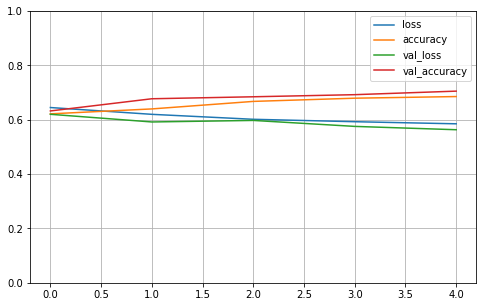

In [17]:
print("Visualize training history.")
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Resources.
[Working with RNNs](https://keras.io/guides/working_with_rnns/).
[Recurrent Neural Networks with Keras](https://www.tensorflow.org/guide/keras/rnn#rnns_with_listdict_inputs_or_nested_inputs).
Function tf.convert_to_tensor [docs](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor).
Function tf.reshape [docs](https://www.tensorflow.org/api_docs/python/tf/reshape).
Ragged Tensors [tutorial](https://www.tensorflow.org/guide/tensor#ragged_tensors)
and [docs](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#documenting_raggedtensor_shapes_2) and [module](https://www.tensorflow.org/api_docs/python/tf/ragged).
Incredible speedup for convert to tensor by sirfz on [stackoverflow](https://stackoverflow.com/questions/44353509/tensorflow-tf-constant-initializer-is-very-slow).


